In [2]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

class HarveyData(Dataset):
    def __init__(self, dataset_dir, image_size=224, augment_data=True):
        self.dataset_dir = dataset_dir
        self.image_size = image_size
        self.augment_data = augment_data

        self.pre_image_paths = sorted(os.listdir(os.path.join(dataset_dir, 'pre_img')))
        self.mask_paths = sorted(os.listdir(os.path.join(dataset_dir, 'pre_msk')))
        self.num_images = len(self.pre_image_paths)

    def __getitem__(self, idx):
        pre_image_path = os.path.join(self.dataset_dir, 'pre_img', self.pre_image_paths[idx])
        mask_path = os.path.join(self.dataset_dir, 'pre_msk', self.mask_paths[idx])

        pre_image = Image.open(pre_image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        # Apply data augmentation
        if self.augment_data:
            pre_image, mask = self.apply_augmentations(pre_image, mask)

        # Transformations for resizing and normalization
        transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        mask_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
        ])

        pre_image = transform(pre_image)
        mask = mask_transform(mask)

        # Binarize the mask: you might need to adjust the threshold based on your mask data
        mask = (mask > 0.5).float()

        return pre_image, mask

    def apply_augmentations(self, image, mask):
        # Example augmentation: Random horizontal flip
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        return image, mask

    def __len__(self):
        return self.num_images


[0. 1.] [41796  8380]


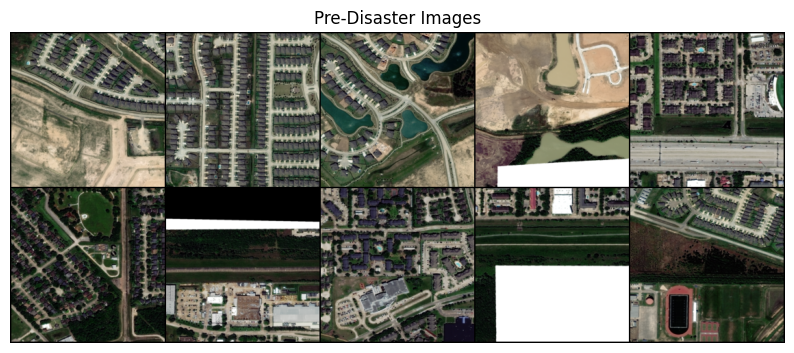

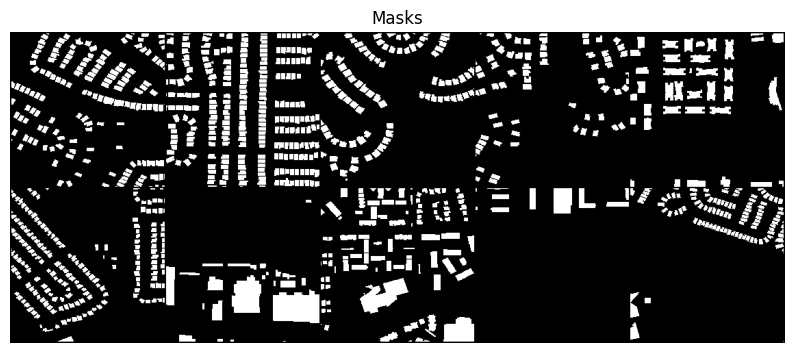

In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
# Assuming HarveyData is defined in the current context

def show_images(images, title=''):
    """Function to show a batch of images"""
    plt.figure(figsize=(10, 5))
    plt.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

def main():
    # Initialize the dataset and DataLoader
    dataset_dir = './dataset/training'  # Update this path to your dataset directory
    dataset = HarveyData(dataset_dir, image_size=224, augment_data=True)
    data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

    # Fetch a batch of data
    it = iter(data_loader)
    pre_images, masks = next(it)

    # Denormalize pre_images for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    pre_images = pre_images * std + mean  # Denormalize
    pre_images = torch.clamp(pre_images, 0, 1)  # Clamp to valid image range

    # Display pre-disaster images
    show_images(pre_images, title='Pre-Disaster Images')

    # Display masks
    show_images(masks, title='Masks')
    unique, counts = np.unique(masks[0][0], return_counts=True)
    print(unique, counts)
    plt.show()

if __name__ == "__main__":
    main()


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting Path
        self.c1 = ConvBlock(in_channels, 32)
        self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.c2 = ConvBlock(32, 64)
        self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.c3 = ConvBlock(64, 128)
        self.p3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.c4 = ConvBlock(128, 256)
        self.p4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.c5 = ConvBlock(256, 512)

        # Expansive Path
        self.up6 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.c6 = ConvBlock(512, 256)

        self.up7 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.c7 = ConvBlock(256, 128)

        self.up8 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.c8 = ConvBlock(128, 64)

        self.up9 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.c9 = ConvBlock(64, 32)

        # Output layer
        self.output = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        c1 = self.c1(x)
        p1 = self.p1(c1)

        c2 = self.c2(p1)
        p2 = self.p2(c2)

        c3 = self.c3(p2)
        p3 = self.p3(c3)

        c4 = self.c4(p3)
        p4 = self.p4(c4)

        c5 = self.c5(p4)

        u6 = self.up6(c5)
        u6 = torch.cat((u6, c4), dim=1)
        c6 = self.c6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat((u7, c3), dim=1)
        c7 = self.c7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat((u8, c2), dim=1)
        c8 = self.c8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat((u9, c1), dim=1)
        c9 = self.c9(u9)

        output = self.output(c9)
        return output


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# Assuming UNet and HarveyData classes are defined

def calculate_accuracy(outputs, labels):
    with torch.no_grad():
        preds = torch.sigmoid(outputs) > 0.5
        correct = (preds == labels).float()
        accuracy = correct.sum() / correct.numel()
    return accuracy.item()

def train_model(model, train_loader, val_loader, epochs, device):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

        # Validation accuracy check
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), 'latest.pth')
            model.eval()
            val_accuracy = 0.0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_accuracy += calculate_accuracy(outputs, masks)

            val_accuracy /= len(val_loader)
            print(f'Validation Accuracy after Epoch {epoch+1}: {val_accuracy}')

    print('Finished Training')

# Dataset and DataLoader setup
dataset_dir = './dataset/training'  # Update to your dataset directory
dataset = HarveyData(dataset_dir, image_size=240, augment_data=True)

# Splitting dataset into training and validation
val_percent = 0.2  # 20% for validation
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

# Model setup
model = UNet(in_channels=3, out_channels=1)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Start training
train_model(model, train_loader, val_loader, epochs=80, device=device)


In [5]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import jaccard_score  # For IoU calculation

# Assuming HarveyData and UNet are defined in the current context

def test_model(model, dataloader, device):
    model.to(device)
    model.eval()  # Set model to evaluation mode
    
    ious = []  # List to store IoU for each batch

    with torch.no_grad():  # No need to compute gradient
        for images, true_masks in dataloader:
            images = images.to(device)
            true_masks = true_masks.to(device)

            # Forward pass
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = (preds > 0.5).float()  # Threshold predictions

            # Compute IoU
            preds_np = preds.cpu().numpy().flatten()
            true_masks_np = true_masks.cpu().numpy().flatten()
            iou = jaccard_score(true_masks_np, preds_np, average='binary')
            ious.append(iou)
    
    avg_iou = np.mean(ious)
    print(f'Average IoU on the test set: {avg_iou:.4f}')

# Parameters
batch_size = 4  # Adjust based on your GPU memory

# Test dataset and DataLoader
test_dataset_dir = './dataset/testing'  # Update this path to your test dataset directory
test_dataset = HarveyData(test_dataset_dir, image_size=224, augment_data=False)  # No augmentation for testing
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
in_channels = 3  # Input image channels
out_channels = 1  # Output channels, 1 for binary segmentation
model = UNet(in_channels, out_channels)

# Load the trained model weights
model_path = 'latest.pth'  # Update this path
model.load_state_dict(torch.load(model_path))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test the model
test_model(model, test_dataloader, device)


Average IoU on the test set: 0.6159


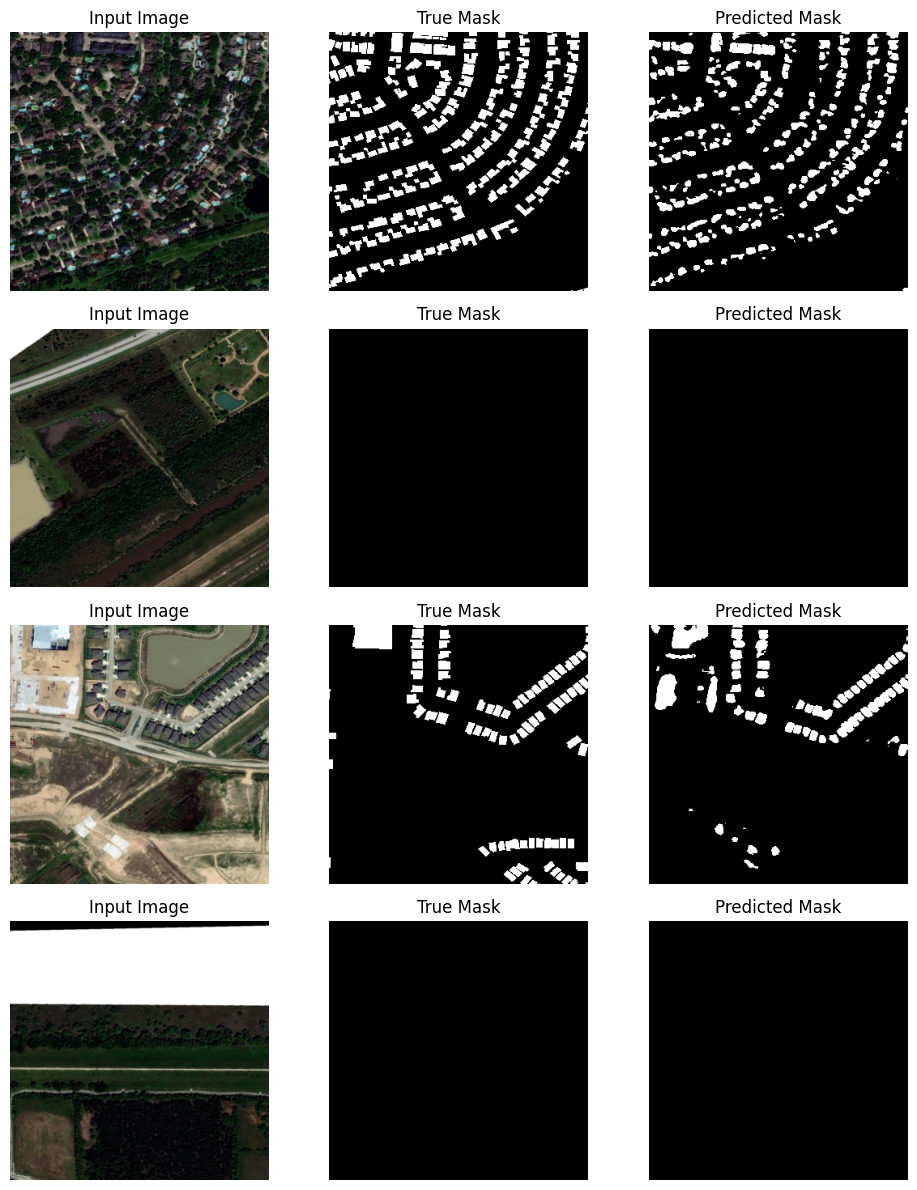

In [6]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Assuming model, HarveyData, and device are already defined

def visualize_predictions(dataset, model, device, num_samples=4):
    dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, true_masks = next(iter(dataloader))
    images, true_masks = images.to(device), true_masks.to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold to get binary predictions

    images = images.cpu()
    true_masks = true_masks.cpu()
    preds = preds.cpu()

    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))
    for i in range(num_samples):
        axs[i, 0].imshow(images[i].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))  # Unnormalize
        axs[i, 0].set_title('Input Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(true_masks[i].squeeze(), cmap='gray')
        axs[i, 1].set_title('True Mask')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Load a sample dataset for visualization
dataset = HarveyData('dataset/testing', image_size=320, augment_data=False)  # Make sure to adjust the path

# Visualize predictions
visualize_predictions(dataset, model, device, num_samples=4)


In [7]:
dataset = HarveyData('dataset/testing', image_size=720, augment_data=False)  # Make sure to adjust the path
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
images, true_masks = next(iter(dataloader))
images, true_masks = images.to(device), true_masks.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold to get binary predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


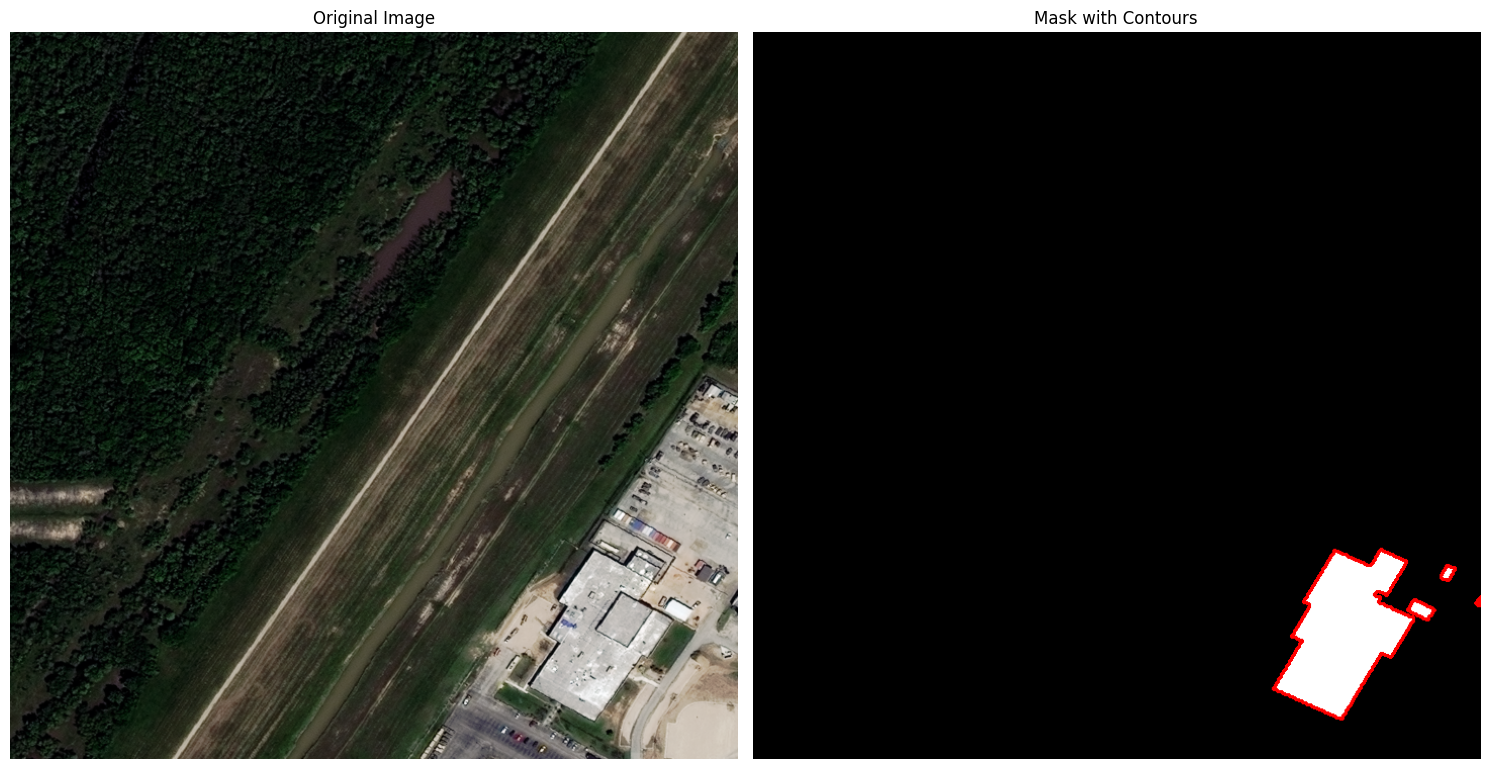

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assuming you have a DataLoader 'dataloader'

# Get the first batch from the dataloader
images, true_masks = next(iter(dataloader))

# Convert the images and masks to numpy arrays for visualization
image_np = images[0].numpy().transpose(1, 2, 0)
true_mask_np = true_masks[0].numpy().squeeze()
# Un-normalize the image if it was normalized during preprocessing
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

# Find contours from the true mask
contours, _ = cv2.findContours(true_mask_np.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the true mask for drawing contours on it
mask_with_contours = np.stack((true_mask_np,)*3, axis=-1)  # Convert to a 3-channel image for visualization

# Draw contours on the mask
for contour in contours:
    cv2.drawContours(mask_with_contours, [contour], -1, (255, 0, 0), 2)  # Red contours

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot the original image
axes[0].imshow(image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the mask with contours
axes[1].imshow(mask_with_contours)
axes[1].set_title('Mask with Contours')
axes[1].axis('off')

# Display the plots
plt.tight_layout()
plt.show()


4


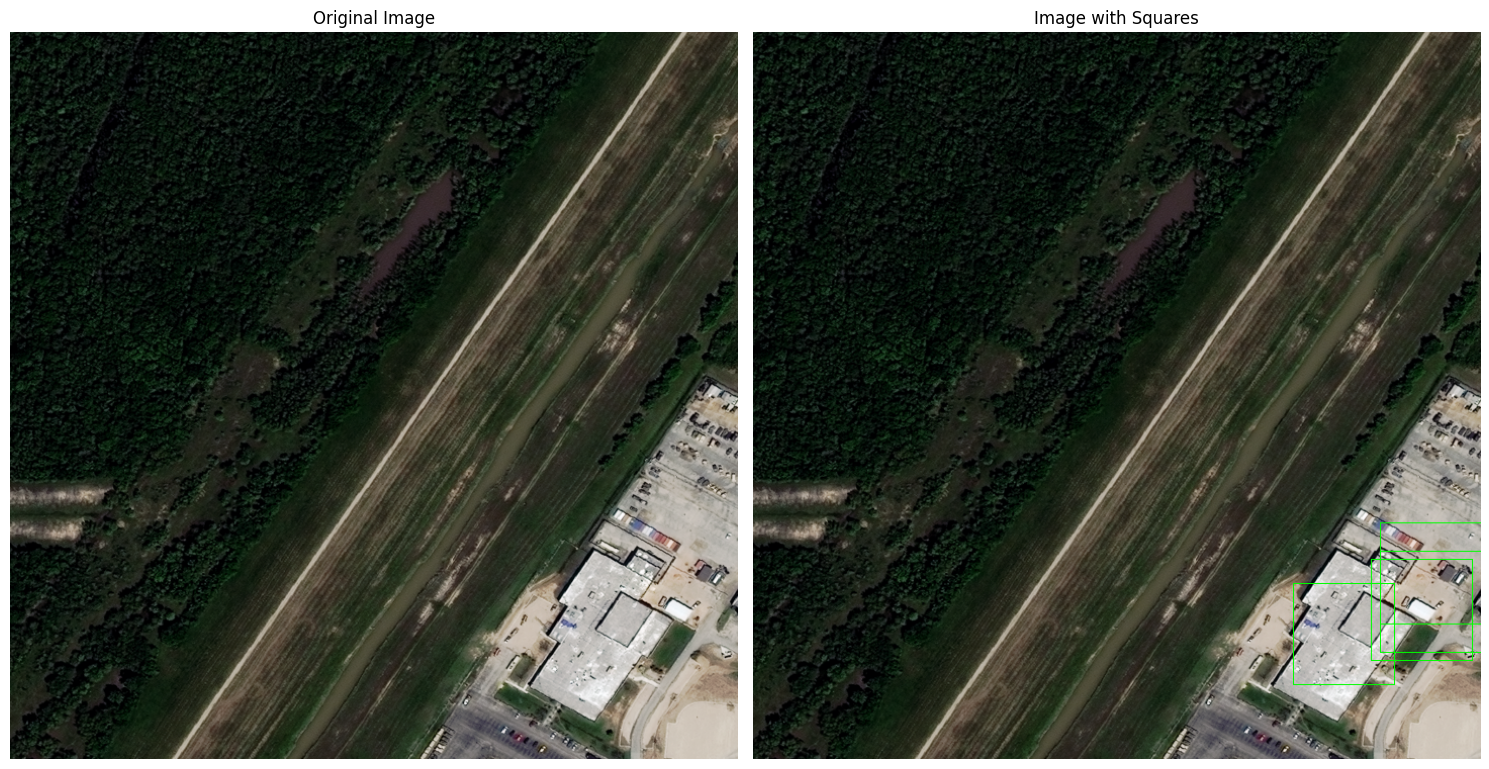

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assuming images and true_masks are already loaded

# Define the square size
square_size = 100  # Each side of the square will be 50 pixels

# Convert the images and masks to numpy arrays for visualization
image_np = images[0].numpy().transpose(1, 2, 0)
true_mask_np = true_masks[0].numpy().squeeze()

# Normalize the image for display
image_np = (image_np * std + mean) * 255.0
image_np = np.clip(image_np, 0, 255).astype(np.uint8)

# Find contours from the true mask
contours, _ = cv2.findContours(true_mask_np.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image for drawing squares
image_with_squares = np.ascontiguousarray(np.copy(image_np))
print(len(contours))
# Draw squares around each contour
for contour in contours:
    # Calculate the bounding rectangle to find the center
    x, y, w, h = cv2.boundingRect(contour)
    center_x, center_y = x + w // 2, y + h // 2

    # Calculate the top-left corner of the square
    top_left_x = max(center_x - square_size // 2, 0)
    top_left_y = max(center_y - square_size // 2, 0)

    # Ensure the square doesn't go beyond the image boundaries
    bottom_right_x = min(top_left_x + square_size, image_with_squares.shape[1])
    bottom_right_y = min(top_left_y + square_size, image_with_squares.shape[0])

    # Adjust the top left if necessary to keep the square within bounds
    if bottom_right_x - top_left_x < square_size:
        top_left_x = bottom_right_x - square_size
    if bottom_right_y - top_left_y < square_size:
        top_left_y = bottom_right_y - square_size

    # Draw the square
    cv2.rectangle(image_with_squares, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 1)  # Green squares

# Plotting the original image and the image with squares
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Original image
axes[0].imshow(image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Image with squares
axes[1].imshow(image_with_squares)
axes[1].set_title('Image with Squares')
axes[1].axis('off')

plt.tight_layout()
plt.show()


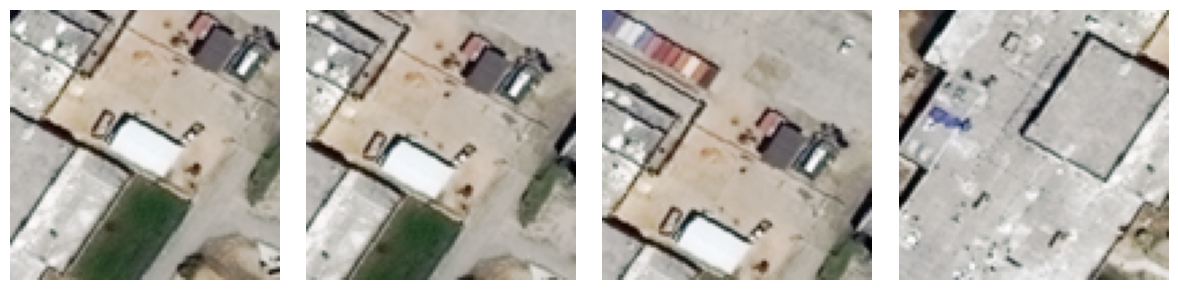

In [10]:
def crop_and_display_squares(image_np, contours, square_size=80):
    cropped_squares = []
    
    # Crop squares from the image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2

        top_left_x = max(center_x - square_size // 2, 0)
        top_left_y = max(center_y - square_size // 2, 0)

        bottom_right_x = min(top_left_x + square_size, image_np.shape[1])
        bottom_right_y = min(top_left_y + square_size, image_np.shape[0])

        # Adjust the top left if necessary to keep the square within bounds
        if bottom_right_x - top_left_x < square_size:
            top_left_x = bottom_right_x - square_size
        if bottom_right_y - top_left_y < square_size:
            top_left_y = bottom_right_y - square_size

        cropped = image_np[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        if cropped.shape[0] == square_size and cropped.shape[1] == square_size:
            cropped_squares.append(cropped)
    
    # Display all cropped squares
    num_crops = len(cropped_squares)
    cols = min(num_crops, 5)  # Display up to 5 images per row
    rows = num_crops // cols + (1 if num_crops % cols else 0)
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.flatten() if num_crops > 1 else [axs]
    
    for i, crop in enumerate(cropped_squares):
        axs[i].imshow(crop)
        axs[i].axis('off')
    
    # Hide any remaining axes if they exist
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming you have already found contours and have the image_np variable from previous steps
crop_and_display_squares(image_np, contours, square_size=100)


In [11]:
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

class BuildingCropDataset(Dataset):
    def __init__(self, dataset_dir, square_size=50, transform=None):
        self.dataset_dir = dataset_dir
        self.square_size = square_size
        self.transform = transform
        
        # Assuming post-disaster images and masks are stored in these directories
        self.post_image_paths = sorted(os.listdir(os.path.join(dataset_dir, 'post_img')))
        self.mask_paths = sorted(os.listdir(os.path.join(dataset_dir, 'pre_msk')))
        
    def __len__(self):
        return len(self.post_image_paths)
    
    def __getitem__(self, idx):
        post_img_path = os.path.join(self.dataset_dir, 'post_img', self.post_image_paths[idx])
        mask_path = os.path.join(self.dataset_dir, 'pre_msk', self.mask_paths[idx])
        
        # Load the post-disaster image and mask
        post_image = Image.open(post_img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        # Convert PIL images to numpy arrays
        post_image_np = np.array(post_image)
        mask_np = np.array(mask)
        # Convert values less than 100 to 0, and values 100 or above to 255
        mask_np = np.where(mask_np < 100, 0, 255).astype(np.uint8)

        # Find contours from the mask
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Crop buildings from the post-disaster image
        buildings = self.crop_buildings(post_image_np, contours)
        
        # Apply transformations if any
        if self.transform is not None:
            post_image = self.transform(post_image)
            buildings = [self.transform(Image.fromarray(building)) for building in buildings]
        
        return post_image, buildings
    
    def crop_buildings(self, image, contours):
        cropped_buildings = []
        offset = self.square_size // 2

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            center_x, center_y = x + w // 2, y + h // 2
            
            top_left_x = max(center_x - offset, 0)
            top_left_y = max(center_y - offset, 0)

            bottom_right_x = min(top_left_x + self.square_size, image.shape[1])
            bottom_right_y = min(top_left_y + self.square_size, image.shape[0])
            
            cropped_building = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
            if cropped_building.shape[0] == self.square_size and cropped_building.shape[1] == self.square_size:
                cropped_buildings.append(cropped_building)
        
        return cropped_buildings

# Define a transform (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset and dataloader
dataset = BuildingCropDataset('dataset/testing', square_size=100, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
i = 0
# Example usage
for post_image, buildings in dataloader:
    print(post_image.shape)  # Tensor of shape [B, C, H, W]
    print(len(buildings))  # List of tensors of cropped buildings
    break

torch.Size([1, 3, 1021, 1021])
80


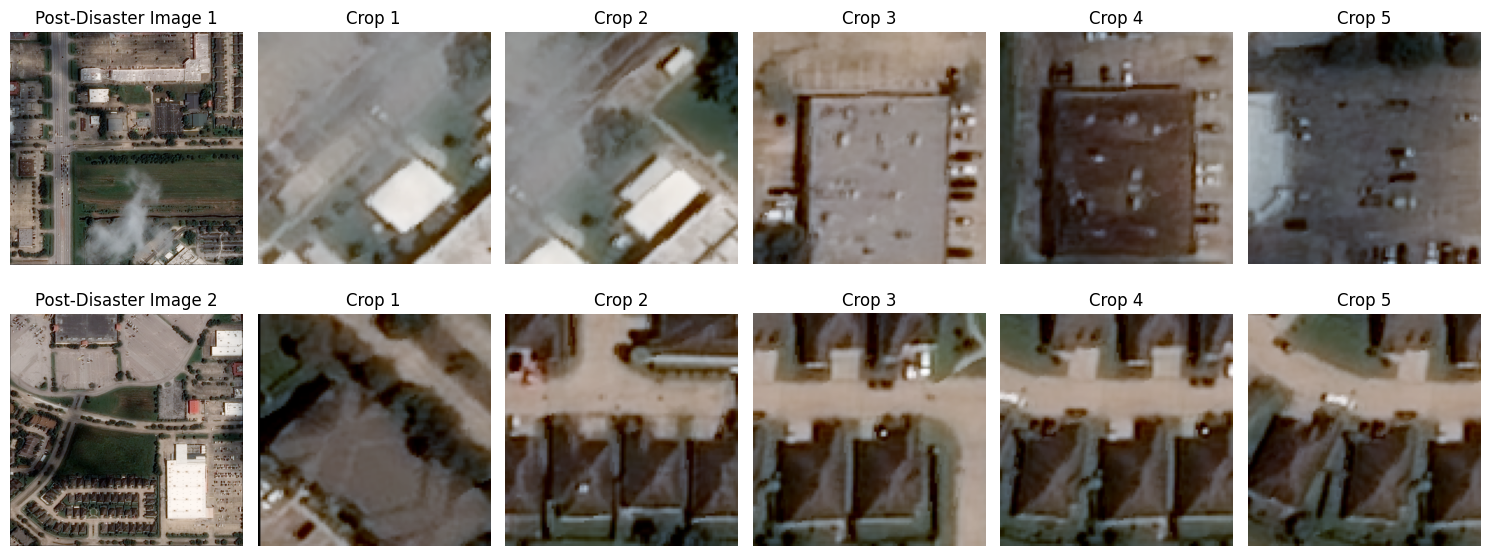

In [12]:
# Function to denormalize and display a single image
def display_image(ax, image, title, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Denormalize the image
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # Denormalize
    image = image.clamp(0, 1)  # Clamp to valid image range

    # Convert to numpy for display
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Reorder dimensions to HWC for matplotlib
    ax.imshow(image_np)
    ax.set_title(title)
    ax.axis('off')

# Update the display_examples function to include denormalization parameters
def display_examples(dataloader, num_examples=2, crops_per_image=5):
    fig, axes = plt.subplots(num_examples, crops_per_image + 1, figsize=(15, num_examples * 3))
    
    for i, (post_image, buildings) in enumerate(dataloader):
        if i >= num_examples: break  # Display only the first 'num_examples' examples
        
        # Display the post-disaster image with denormalization
        display_image(axes[i, 0], post_image[0], f'Post-Disaster Image {i+1}')
        
        # Display some of the cropped buildings with denormalization
        for j in range(min(crops_per_image, len(buildings))):
            crop = buildings[j]
            display_image(axes[i, j + 1], crop[0], f'Crop {j+1}')
        
        # If there are fewer crops than the space allows, hide the remaining axes
        for j in range(len(buildings), crops_per_image + 1):
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming the 'dataloader' has been defined as shown previously
display_examples(dataloader)


In [13]:
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torch

class BuildingDamageDataset(Dataset):
    def __init__(self, dataset_dir, square_size=50, transform=None):
        self.dataset_dir = dataset_dir
        self.square_size = square_size
        self.transform = transform
        
        # Assuming post-disaster images, pre-disaster masks, and PDE_labels are stored in these directories
        self.post_image_paths = sorted(os.listdir(os.path.join(dataset_dir, 'post_img')))
        self.pre_mask_paths = sorted(os.listdir(os.path.join(dataset_dir, 'pre_msk')))
        self.pde_label_paths = sorted(os.listdir(os.path.join(dataset_dir, 'PDE_labels')))
        
    def __len__(self):
        return len(self.post_image_paths)
    
    def __getitem__(self, idx):
        post_img_path = os.path.join(self.dataset_dir, 'post_img', self.post_image_paths[idx])
        pre_mask_path = os.path.join(self.dataset_dir, 'pre_msk', self.pre_mask_paths[idx])
        pde_label_path = os.path.join(self.dataset_dir, 'PDE_labels', self.pde_label_paths[idx])
        
        # Load the post-disaster image, pre-disaster mask, and PDE_labels mask
        post_image = Image.open(post_img_path).convert('RGB')
        pre_mask = Image.open(pre_mask_path).convert('L')
        pde_label = Image.open(pde_label_path).convert('L')
        
        post_image_np = np.array(post_image)
        
        pre_mask_np = np.array(pre_mask)
        pre_mask_np = np.where(pre_mask_np < 100, 0, 255).astype(np.uint8)
        pde_label_np = np.array(pde_label)
        
        # Find contours from the pre-disaster mask
        contours, _ = cv2.findContours(pre_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Crop buildings from the post-disaster image and get damage levels from the PDE_labels mask
        buildings, damage_levels = self.crop_buildings_with_damage(post_image_np, pde_label_np, contours)
        
        if self.transform is not None:
            post_image = self.transform(post_image)
            buildings = [self.transform(Image.fromarray(building)) for building in buildings]
        
        # Convert damage_levels list to a tensor
        damage_levels = torch.tensor(damage_levels, dtype=torch.long)
        
        return post_image, buildings, damage_levels
    
    def crop_buildings_with_damage(self, image, pde_label, contours):
        cropped_buildings = []
        damage_levels = []
        offset = self.square_size // 2

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            center_x, center_y = x + w // 2, y + h // 2
            
            top_left_x = max(center_x - offset, 0)
            top_left_y = max(center_y - offset, 0)
            bottom_right_x = min(top_left_x + self.square_size, image.shape[1])
            bottom_right_y = min(top_left_y + self.square_size, image.shape[0])
            
            cropped_building = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
            cropped_pde_label = pde_label[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

            if cropped_building.shape[0] == self.square_size and cropped_building.shape[1] == self.square_size:
                cropped_buildings.append(cropped_building)
                # Filter out the background value (4) and calculate mode of remaining values
                filtered_labels = cropped_pde_label[cropped_pde_label != 4]
                if filtered_labels.size > 0:
                    unique, counts = np.unique(filtered_labels, return_counts=True)
                    damage_scale = unique[np.argmax(counts)]
                else:
                    # Handle case where no valid damage level is present (e.g., entirely background)
                    damage_scale = 4  # Or consider setting a default or placeholder value

                damage_levels.append(damage_scale)

        return cropped_buildings, damage_levels

# Define a transform (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset and dataloader
dataset = BuildingDamageDataset('dataset/training', square_size=80, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

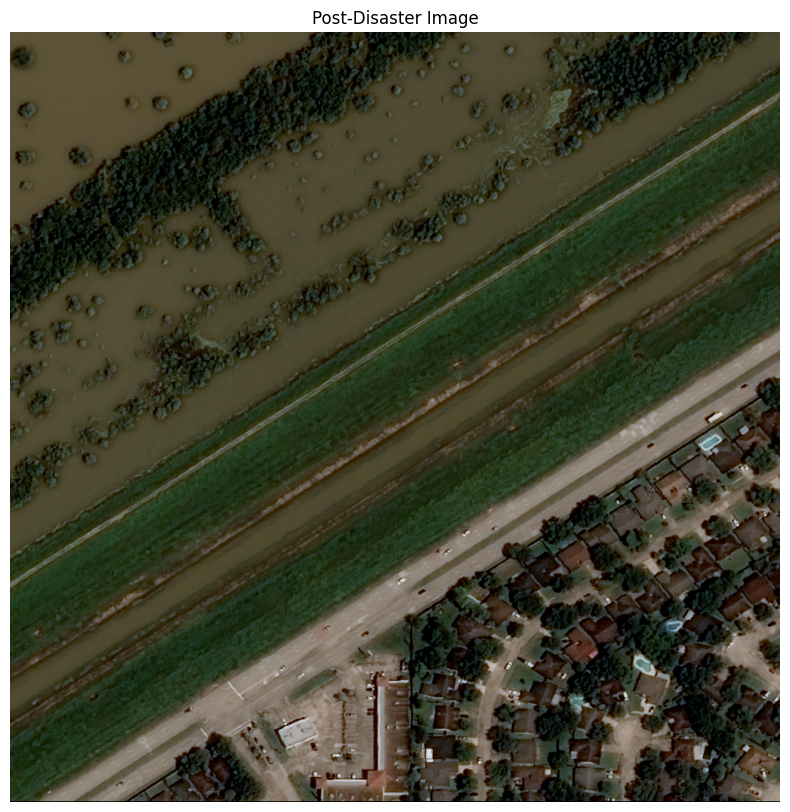

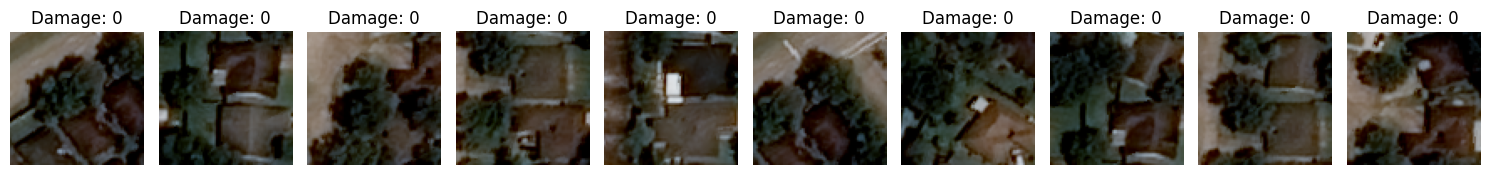

In [14]:
def display_building_crops(post_image, buildings, damage_levels, num_buildings=5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Convert mean and std to tensors for operations
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)

    # Display the post-disaster image
    plt.figure(figsize=(10, 10))
    post_image_denorm = post_image * std + mean  # Denormalize
    post_image_denorm = torch.clamp(post_image_denorm, 0, 1)  # Clamp to valid image range
    plt.imshow(post_image_denorm.permute(1, 2, 0))
    plt.title('Post-Disaster Image')
    plt.axis('off')
    plt.show()

    # Determine the number of buildings to display
    num_buildings = min(num_buildings, len(buildings))
 
    # Display cropped buildings and their damage levels
    fig, axs = plt.subplots(1, num_buildings, figsize=(15, 3))
    if num_buildings == 1:
        axs = [axs]  # Ensure axs is iterable
    for i, building in enumerate(buildings[:num_buildings]):
        
        building_denorm = building[0] * std + mean  # Denormalize
        building_denorm = torch.clamp(building_denorm, 0, 1)  # Clamp
        axs[i].imshow(building_denorm.permute(1, 2, 0))
        axs[i].set_title(f'Damage: {damage_levels[0][i].item()}')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Assuming the 'dataloader' has been defined as shown previously
for post_image, buildings, damage_levels in dataloader:
    # Assuming the first element of the batch is used for demonstration

    display_building_crops(post_image[0], buildings, damage_levels, num_buildings=10)
    break  # Display the first batch


In [15]:
# Initialize a dictionary to count buildings per damage class
damage_class_counts = {0: 0, 1: 0, 2: 0, 3: 0}

for _, _, damage_levels in dataloader:
    damage_levels = damage_levels.numpy()[0]
    for damage_level in damage_levels:
        if damage_level in damage_class_counts:
            damage_class_counts[damage_level.item()] += 1
        else:
            # This handles unexpected damage levels, just in case
            if "others" not in damage_class_counts:
                damage_class_counts["others"] = 1
            else:
                damage_class_counts["others"] += 1

# Print the counts
for damage_class, count in damage_class_counts.items():
    print(f"Damage Class {damage_class}: {count} buildings")



Damage Class 0: 16464 buildings
Damage Class 1: 223 buildings
Damage Class 2: 128 buildings
Damage Class 3: 14 buildings


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader

# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the classifier to fit the number of classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)  # Output layer for 4 classes

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


C:\Users\rajsh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rajsh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms
from PIL import Image
import cv2
import rasterio
from torchvision.transforms import Resize

class SingleBuildingDamageDataset(Dataset):
    def __init__(self, dataset_dir, square_size=50, transform=None):
        self.dataset_dir = dataset_dir
        self.square_size = square_size
        self.transform = transform
        self.data = []
        
        post_image_paths = sorted(os.listdir(os.path.join(dataset_dir, 'post_img')))
        pre_mask_paths = sorted(os.listdir(os.path.join(dataset_dir, 'pre_msk')))
        pde_label_paths = sorted(os.listdir(os.path.join(dataset_dir, 'PDE_labels')))
        elevation_paths = sorted(os.listdir(os.path.join(dataset_dir, 'elevation')))
        hand_paths = sorted(os.listdir(os.path.join(dataset_dir, 'hand')))
        imperviousness_paths = sorted(os.listdir(os.path.join(dataset_dir, 'imperviousness')))
        
        resize_transform = Resize((360, 360))
        
        for idx in range(len(post_image_paths)):
            post_img_path = os.path.join(self.dataset_dir, 'post_img', post_image_paths[idx])
            pre_mask_path = os.path.join(self.dataset_dir, 'pre_msk', pre_mask_paths[idx])
            pde_label_path = os.path.join(self.dataset_dir, 'PDE_labels', pde_label_paths[idx])
            elevation_path = os.path.join(self.dataset_dir, 'elevation', elevation_paths[idx])
            hand_path = os.path.join(self.dataset_dir, 'hand', hand_paths[idx])
            imperviousness_path = os.path.join(self.dataset_dir, 'imperviousness', imperviousness_paths[idx])
            
            # Load and resize images and masks
            post_image = resize_transform(Image.open(post_img_path).convert('RGB'))
            pre_mask = resize_transform(Image.open(pre_mask_path).convert('L'))
            pde_label = resize_transform(Image.open(pde_label_path).convert('L'))

            with rasterio.open(elevation_path) as elevation_src, \
                 rasterio.open(hand_path) as hand_src, \
                 rasterio.open(imperviousness_path) as imperviousness_src:
                elevation_band = elevation_src.read(1)
                elevation_img = Image.fromarray(elevation_band)
                elevation_img = resize_transform(elevation_img)
                
                hand_band = hand_src.read(1)
                hand_img = Image.fromarray(hand_band)
                hand_img = resize_transform(hand_img)
                
                imperviousness_band = imperviousness_src.read(1)
                imperviousness_img = Image.fromarray(imperviousness_band)
                imperviousness_img = resize_transform(imperviousness_img)

            pre_mask_np = np.array(pre_mask)
            pre_mask_np = np.where(pre_mask_np < 100, 0, 255).astype(np.uint8)
            contours, _ = cv2.findContours(pre_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                cropped_data = self.crop_layers(contour, np.array(post_image), np.array(elevation_img), np.array(hand_img), np.array(imperviousness_img))
                if cropped_data:
                    building, elevation, hand, imperviousness = cropped_data
                    damage_level = self.get_damage_level(contour, np.array(pde_label))
                    if self.transform:
                        building = self.transform(TF.to_pil_image(building))
                        # elevation = self.transform(TF.to_pil_image(elevation))
                        # hand = self.transform(TF.to_pil_image(hand))
                        # imperviousness = self.transform(TF.to_pil_image(imperviousness))
                    elevation_channel = TF.to_tensor(elevation)
                    hand_channel = TF.to_tensor(hand)
                    imperviousness_channel = TF.to_tensor(imperviousness)

                    six_channel_image = torch.cat((building, elevation_channel, hand_channel, imperviousness_channel), dim=0)

                    self.data.append((six_channel_image, damage_level))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        six_channel_image, damage_level = self.data[idx]
        return six_channel_image, damage_level
    
    def crop_layers(self, contour, post_image, elevation, hand, imperviousness):
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2
        
        top_left_x = max(center_x - self.square_size // 2, 0)
        top_left_y = max(center_y - self.square_size // 2, 0)
        bottom_right_x = min(top_left_x + self.square_size, post_image.shape[1])
        bottom_right_y = min(top_left_y + self.square_size, post_image.shape[0])
        
        if bottom_right_x - top_left_x == self.square_size and bottom_right_y - top_left_y == self.square_size:
            return (
                post_image[top_left_y:bottom_right_y, top_left_x:bottom_right_x],
                elevation[top_left_y:bottom_right_y, top_left_x:bottom_right_x],
                hand[top_left_y:bottom_right_y, top_left_x:bottom_right_x],
                imperviousness[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
            )
        return None
    
    def get_damage_level(self, contour, pde_label):
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2
        
        top_left_x = max(center_x - self.square_size // 2, 0)
        top_left_y = max(center_y - self.square_size // 2, 0)
        bottom_right_x = min(top_left_x + self.square_size, pde_label.shape[1])
        bottom_right_y = min(top_left_y + self.square_size, pde_label.shape[0])
        
        cropped_pde_label = pde_label[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        filtered_labels = cropped_pde_label[cropped_pde_label != 255]
        if filtered_labels.size > 0:
            unique, counts = np.unique(filtered_labels, return_counts=True)
            return torch.tensor(unique[np.argmax(counts)], dtype=torch.long)
        return torch.tensor(255, dtype=torch.long)  # Placeholder for undetermined or no damage


In [5]:
# Assuming the transform is defined as before

from torchvision import transforms

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleBuildingDamageDataset('dataset\\training', square_size=80, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch_size as needed

# You can now proceed to train your model using this dataloader


In [6]:
import torch.nn as nn
import torchvision.models as models

def adapt_vgg_to_six_channels(vgg_model, num_classes=4, init_method=None):
    # Modify the first convolutional layer to accept 6 channels
    original_first_layer = vgg_model.features[0]
    new_first_layer = nn.Conv2d(6, original_first_layer.out_channels, kernel_size=original_first_layer.kernel_size, 
                                stride=original_first_layer.stride, padding=original_first_layer.padding)
    if init_method == "copy":
        with torch.no_grad():
            # Copy weights for the first 3 channels from the pre-trained model, initialize the rest
            new_first_layer.weight[:, :3] = original_first_layer.weight.clone()
            nn.init.constant_(new_first_layer.weight[:, 3:], 0.01)  # Initialize the new channels
    vgg_model.features[0] = new_first_layer

    # Adjust the final classifier layer to output 4 classes
    num_features = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_features, num_classes)
    
    return vgg_model

# Load VGG without pretrained weights for illustration
vgg16_random_weights = models.vgg16(pretrained=False)
# Adapt for 6-channel input and ensure it classifies into 4 classes
vgg16_adapted = adapt_vgg_to_six_channels(vgg16_random_weights, num_classes=4, init_method="copy")


# Load the pre-trained VGG model
vgg16_pretrained = models.vgg16(pretrained=True)
vgg16_adapted = adapt_vgg_to_six_channels(vgg16_pretrained, init_method="copy")

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_adapted = vgg16_adapted.to(device)


C:\Users\rajsh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import matplotlib.pyplot as plt
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Function to display a batch of images and labels
def show_batch_images(images, labels, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = images[i].numpy().transpose(1, 2, 0)  # Convert from tensor to HWC format for matplotlib
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
        
        axs[i].imshow(img)
        axs[i].set_title(f'Damage: {labels[i].item()}')
        axs[i].axis('off')
    plt.show()

# Assuming you have a DataLoader `dataloader` already defined and loaded with the dataset
# Let's fetch one batch of images and labels
for images, labels in dataloader:
    show_batch_images(images, labels, num_images=min(5, len(images)))  # Display up to 5 images from the batch
    break  # Only show the first batch


In [10]:
from torch.utils.data import DataLoader, random_split

# Assume adapt_vgg_to_six_channels is defined as discussed
vgg16_adapted = models.vgg16(pretrained=False)  # Start without pretrained weights
vgg16_adapted = adapt_vgg_to_six_channels(vgg16_adapted, num_classes=4, init_method="copy")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_adapted.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_adapted.parameters(), lr=0.001)

def train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_dataloader)}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        print(f'Epoch {epoch+1}, Validation Loss: {val_running_loss / len(val_dataloader)}')

# Split your dataset into training and validation sets as described previously
# Assume train_dataloader and val_dataloader are already defined
val_percent = 0.2  # 20% of the dataset for validation
num_val = int(len(dataset) * val_percent)
num_train = len(dataset) - num_val
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])
batch_size = 16  # Adjust based on your GPU memory

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


train_and_validate(vgg16_adapted, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10)


In [233]:
from torch.utils.data.dataset import random_split

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10, save_path='model'):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_loss = running_loss / len(train_dataloader)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        
        val_loss = val_running_loss / len(val_dataloader)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        
        # Save the model every 5 epochs and if it has the best validation loss
        if (epoch + 1) % 5 == 0 or val_loss < best_val_loss:
            best_val_loss = min(best_val_loss, val_loss)
            torch.save(model.state_dict(), f"{save_path}_epoch_{epoch+1}.pth")
    
    print('Finished Training')

# Assuming you have defined 'dataset' as an instance of SingleBuildingDamageDataset
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Now, call the updated train_model function with training and validation dataloaders
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=50, save_path='vgg16_building_damage')


Epoch 1/50, Train Loss: 0.13433633743721168, Val Loss: 0.09547979525237713
Epoch 2/50, Train Loss: 0.13129847396647384, Val Loss: 0.09577703481223786
Epoch 3/50, Train Loss: 0.13075799940733546, Val Loss: 0.09614652607871114
Epoch 4/50, Train Loss: 0.13034531007124878, Val Loss: 0.0964188976213336
Epoch 5/50, Train Loss: 0.1299361442801965, Val Loss: 0.09713764910428029
Epoch 6/50, Train Loss: 0.13028681006353357, Val Loss: 0.09556715305508026
Epoch 7/50, Train Loss: 0.13065337999380966, Val Loss: 0.09624395236583813
Epoch 8/50, Train Loss: 0.13005129921066436, Val Loss: 0.09634034967331111
Epoch 9/50, Train Loss: 0.12915507752023583, Val Loss: 0.09631927819254826
Epoch 10/50, Train Loss: 0.1301495781225858, Val Loss: 0.09594748265830413
Epoch 11/50, Train Loss: 0.13012577901260303, Val Loss: 0.09570513250973989
Epoch 12/50, Train Loss: 0.1299659101659711, Val Loss: 0.09564979411310183
Epoch 13/50, Train Loss: 0.1300034412136412, Val Loss: 0.09614576608434601
Epoch 14/50, Train Loss: 0

In [234]:
# Assuming you have a test dataset set up similar to your training/validation dataset
test_dataset = SingleBuildingDamageDataset('dataset/testing', square_size=80, transform=transform) # Use the appropriate transform
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Adjust batch_size as needed


In [238]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np

def test_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)

    recall = recall_score(all_labels, all_predictions, average='macro')

    print(f'Accuracy on the test set: {accuracy:.2f}')
    print(f'Precision on the test set: {precision:.2f}')
    print(f'Recall on the test set: {recall:.2f}')

test_model(model, test_dataloader)


Accuracy on the test set: 0.95
Precision on the test set: 0.19
Recall on the test set: 0.20
